In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

In [3]:
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import BertTokenizer, BertForMultipleChoice, AdamW, get_linear_schedule_with_warmup
import numpy as np
import random
import time
import datetime
import json
import os

In [4]:
# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [5]:
# Function to read our JSON file
def read_json(folder_path):
    dataset = []
    for item in os.listdir(folder_path):
        with open(os.path.join(folder_path, item), 'r') as file:
            data = json.load(file)
            dataset.extend(data)
    return dataset

In [6]:
# Load and preprocess training and validation data
train_dataset_path = '/content/drive/MyDrive/NLP/Project/data/training_dataset'

train_data = read_json(train_dataset_path)

In [7]:
len(train_data)

2400

In [8]:
# Function to preprocess and tokenize the data
def preprocess_data(data, tokenizer, max_length=512):
    max_num_choices = max(len(item["Answer Choices"]) for item in data)
    input_ids = []
    attention_masks = []
    labels = []

    for item in data:
        choices = item["Answer Choices"]
        question = item["Question"]
        story = item["Story"]
        label = choices.index(item["Answer"])

        # Tokenize each choice along with the story and question
        choices_input_ids = []
        choices_attention_masks = []

        for choice in choices:
            encoded = tokenizer.encode_plus(
                text=story + " " + question + " " + choice,
                add_special_tokens=True,
                max_length=max_length,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'
            )
            choices_input_ids.append(encoded['input_ids'][0])
            choices_attention_masks.append(encoded['attention_mask'][0])

        # Pad the choices to have the same number
        while len(choices_input_ids) < max_num_choices:
            choices_input_ids.append(torch.zeros(max_length, dtype=torch.long))
            choices_attention_masks.append(torch.zeros(max_length, dtype=torch.long))

        # Convert lists to tensors and stack them
        input_ids.append(torch.stack(choices_input_ids))
        attention_masks.append(torch.stack(choices_attention_masks))
        labels.append(label)

    # Convert lists to tensors
    input_ids = torch.stack(input_ids)
    attention_masks = torch.stack(attention_masks)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels

In [9]:
train_input_ids, train_attention_masks, train_labels = preprocess_data(train_data, tokenizer)

In [10]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

2,160 training samples
  240 validation samples


In [11]:
# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 4

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [12]:
model = BertForMultipleChoice.from_pretrained(
    'bert-base-uncased',
    num_labels = len(train_data[0]["Answer Choices"]),
    output_attentions = False,
    output_hidden_states = False,
)

# If there's a GPU available...
if torch.cuda.is_available():
    model.cuda()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [14]:
# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 10

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [15]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [16]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [17]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [18]:
# Seed for reproducibility
import random
import numpy as np
import torch

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    loss_values.append(avg_train_loss)

    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("\nRunning Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

     # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        total_eval_accuracy += tmp_eval_accuracy

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("\nTraining complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

======== Epoch 1 / 10 ========
Training...
  Batch    40  of    540.    Elapsed: 0:00:57.
  Batch    80  of    540.    Elapsed: 0:01:56.
  Batch   120  of    540.    Elapsed: 0:02:54.
  Batch   160  of    540.    Elapsed: 0:03:53.
  Batch   200  of    540.    Elapsed: 0:04:51.
  Batch   240  of    540.    Elapsed: 0:05:50.
  Batch   280  of    540.    Elapsed: 0:06:49.
  Batch   320  of    540.    Elapsed: 0:07:48.
  Batch   360  of    540.    Elapsed: 0:08:46.
  Batch   400  of    540.    Elapsed: 0:09:45.
  Batch   440  of    540.    Elapsed: 0:10:44.
  Batch   480  of    540.    Elapsed: 0:11:42.
  Batch   520  of    540.    Elapsed: 0:12:41.
  Average training loss: 1.32
  Training epcoh took: 0:13:10

Running Validation...
  Accuracy: 0.47
  Validation Loss: 1.20
  Validation took: 0:00:33
======== Epoch 2 / 10 ========
Training...
  Batch    40  of    540.    Elapsed: 0:00:59.
  Batch    80  of    540.    Elapsed: 0:01:57.
  Batch   120  of    540.    Elapsed: 0:02:56.
  Batch   

In [19]:
import numpy as np
import pandas as pd

# Display floats with two decimal places.
pd.set_option('display.precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.32,1.20,0.47,0:13:10,0:00:33
2,1.18,1.17,0.49,0:13:12,0:00:33
3,1.03,1.16,0.52,0:13:11,0:00:33
4,0.87,1.37,0.49,0:13:11,0:00:33
5,0.75,1.44,0.50,0:13:11,0:00:33
6,0.63,1.66,0.53,0:13:11,0:00:33
7,0.52,1.92,0.51,0:13:10,0:00:33
8,0.43,2.29,0.52,0:13:11,0:00:33
9,0.35,2.54,0.52,0:13:12,0:00:33


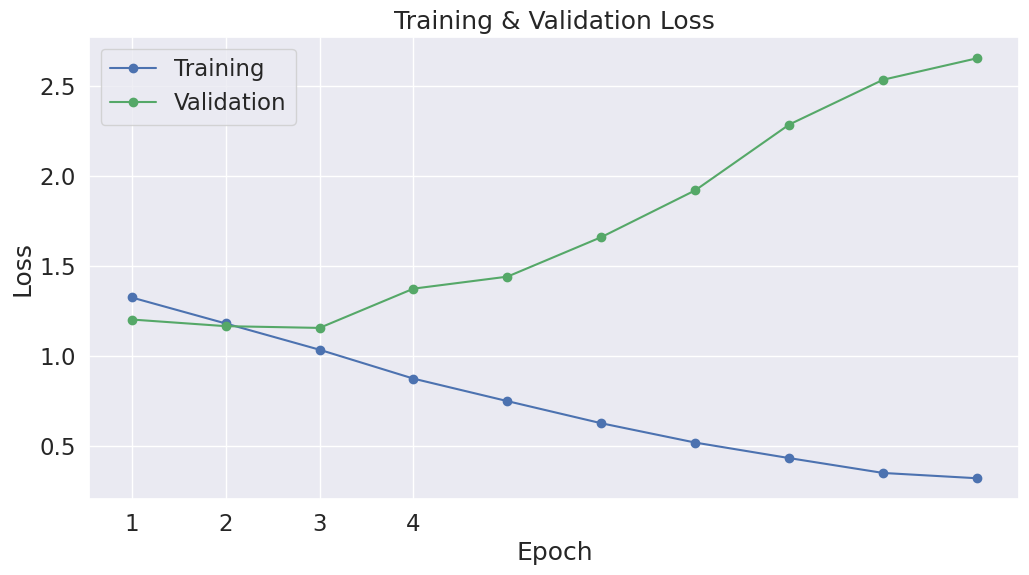

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import pandas as pd

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [21]:
test_dataset_path = '/content/drive/MyDrive/NLP/Project/data/validation_dataset'
test_data = read_json(test_dataset_path)

In [22]:
test_input_ids, test_attention_masks, test_labels = preprocess_data(test_data, tokenizer)

In [23]:
# Combine the training inputs into a TensorDataset.
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

In [24]:
# Create the DataLoader
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

In [25]:
model.eval()

ground_truth = []
predictions = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        result = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask,
            return_dict=True
        )
    logits = result.logits
    logits = logits.detach().cpu().numpy()
    pred_labels = np.argmax(logits, axis=1)
    label_ids = b_labels.to('cpu').numpy()
    predictions.extend(pred_labels.tolist())
    ground_truth.extend(label_ids.tolist())

print(len(predictions), len(ground_truth))

240 240


In [26]:
from sklearn.metrics import classification_report

result_report= classification_report(ground_truth, predictions)
print(result_report)

              precision    recall  f1-score   support

           0       0.32      0.58      0.42        43
           1       0.55      0.35      0.43        86
           2       0.56      0.51      0.53        71
           3       0.39      0.42      0.40        40

    accuracy                           0.45       240
   macro avg       0.45      0.47      0.45       240
weighted avg       0.48      0.45      0.45       240



In [27]:
idx = []
for i in range(len(ground_truth)):
    if ground_truth[i]!=predictions[i]:
        idx.append(i)
print(len(idx))

132


In [28]:
misclassified = []
for i in range(len(idx)):
    data_point = {
        "data": test_data[idx[i]],
        "ground_truth": ground_truth[idx[i]],
        "prediction": predictions[idx[i]]
    }
    misclassified.append(data_point)

In [29]:
random.seed(42)
num_samples = int(0.1 * len(misclassified))
random_misclassified_samples = random.sample(misclassified, num_samples)

In [30]:
with open("/content/drive/MyDrive/NLP/Project/misclassified_data.json", "w") as selected_file:
    json.dump(random_misclassified_samples, selected_file, indent=4)